## Importamos las Librerías

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,OrdinalEncoder

## Cargamos el Dataset

In [84]:
df_bmw=pd.read_csv("C:/Users/mitev/Desktop/Prácticas/BMW_Proyecto/Data/bmw_pricing_v3.csv")
df_bmw.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01


## Funciones

In [85]:
def porcentaje_nulos(df, columnas):
   
    total_filas = len(df)
    porcentaje_nulos = {col: (df[col].isnull().sum() / total_filas) * 100 for col in columnas}
    return porcentaje_nulos

In [86]:
def plot_null_values(df):
    
    # Calcula el porcentaje de valores nulos por columna y los ordena de forma descendente
    df_null_values = df.isnull().mean().sort_values(ascending=False) * 100

    # Establece el tamaño del gráfico
    plt.figure(figsize=(10, 15))

    # Selecciona el primer color de la paleta 'GnBu'
    color = sns.color_palette('GnBu', n_colors=1)

    # Genera un gráfico de barras con seaborn
    ax = sns.barplot(x=df_null_values, y=df_null_values.index, color=color[0])
    
    # Configura el color de fondo de la figura
    ax.figure.set_facecolor('salmon')
    ax.figure.patch.set_alpha(0.1)
    ax.set_facecolor('salmon')

    # Invierte el eje Y para que las columnas con más valores nulos aparezcan arriba
    plt.gca().invert_yaxis()

    # Añade títulos a los ejes y el título principal
    plt.title('Porcentaje de Valores Nulos por Columna')
    plt.xlabel('Porcentaje')
    plt.ylabel('Columnas')

    # Añade los valores de porcentaje en las barras
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 0.5, p.get_y() + p.get_height() / 2, '{:1.2f}%'.format(width),
                 va='center', fontsize=10)

    # Muestra el gráfico
    plt.show()


In [87]:
def plot_outliers(df):
  
    # Establece el estilo de los gráficos
    sns.set(style="whitegrid")

    # Identifica las columnas numéricas de tipo float
    float_columns = df.select_dtypes(include=['float64', 'float32']).columns

    # Lista para almacenar columnas con outliers
    columns_with_outliers = []

    # Cálculo vectorizado de los límites de outliers
    for col in float_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificación de outliers
        if df[(df[col] < lower_bound) | (df[col] > upper_bound)].any().any():
            columns_with_outliers.append(col)

    # Generación de gráficos de caja para columnas con outliers
    for col in columns_with_outliers:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col], color="skyblue")
        plt.title(f'Outliers en la columna: {col}')
        plt.xlabel(col)
        plt.show()

In [88]:
def get_sorted_outliers(df, column, n=5):
    """
    Filtra y ordena los outliers de una columna específica en un DataFrame.

    Args:
    df (pd.DataFrame): El DataFrame a analizar.
    column (str): El nombre de la columna para buscar y ordenar outliers.
    n (int): El número de valores outliers a mostrar. Por defecto es 5.

    Returns:
    pd.DataFrame: Un DataFrame con los primeros `n` valores outliers de la columna especificada, ordenados de mayor a menor.
    """
    # Calcular el rango intercuartil (IQR)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar los valores outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Ordenar los valores outliers por la columna especificada de mayor a menor
    outliers_sorted = outliers.sort_values(by=column, ascending=False)

    # Mostrar los primeros `n` valores outliers
    return outliers_sorted.head(n)

In [89]:
def visualize_data(df, target_col='precio'):
 
    # Configurar el estilo de los gráficos
    sns.set(style="whitegrid")
    
    # Iterar a través de las columnas del DataFrame
    for col in df.columns:
        plt.figure(figsize=(10, 6))
        
        if df[col].dtype.kind in {"O", "b"}:  # Columnas categóricas o booleanas
            sns.countplot(y=col, data=df, hue=col, palette="viridis", legend=False)
            plt.title(f"Conteo de valores en la columna '{col}'")
            plt.xlabel("Conteo")
            plt.ylabel(col)
            plt.show()
        elif df[col].dtype.kind in {"f", "i"}:  # Columnas numéricas
            sns.histplot(df[col], kde=True, color="skyblue")
            plt.title(f"Distribución de la columna '{col}'")
            plt.xlabel(col)
            plt.ylabel("Frecuencia")
            plt.show()
        
        # Gráficos adicionales
        # Gráficos de violín para columnas numéricas
        if df[col].dtype.kind == "i":
            plt.figure(figsize=(10, 6))
            sns.violinplot(x=col, y=target_col, data=df)
            plt.title(f"Gráfico de violín de '{col}' vs '{target_col}'")
            plt.xlabel(col)
            plt.ylabel(target_col)
            plt.show()
        
        # Gráficos de dispersión para columnas numéricas excepto 'target_col'
        if df[col].dtype.kind in {"i", "f"} and col != target_col:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=col, y=target_col, data=df)
            plt.title(f"Gráfico de dispersión de '{col}' vs '{target_col}'")
            plt.xlabel(col)
            plt.ylabel(target_col)
            plt.show()
        
        # Gráficos de violín para columnas categóricas excepto 'marca_modelo'
        if df[col].dtype.kind == "O" and col != "marca_modelo":
            plt.figure(figsize=(10, 6))
            sns.violinplot(x=col, y=target_col, data=df)
            plt.title(f"Gráfico de violín de '{col}' vs '{target_col}'")
            plt.xlabel(col)
            plt.ylabel(target_col)
            plt.show()


In [90]:
# Clasificamos las columnas en listas numéricas, booleanas y categóricas.
target= ["precio","RAIZ_PRECIO","LOG_PRECIO"]
def obtener_lista_variables(dataset):
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]
    for i in dataset:
        if    (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i") and len(dataset[i].unique())!= 2  and i not in target:
              lista_numericas.append(i)
        elif  (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i")  and len(dataset[i].unique())== 2  and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind=="O")  and i not in target:
              lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas

In [91]:
def minmaxTransformacion(variable_transformar):
    minMaxResultado=MinMaxScaler()
    df_bmw_prep[variable_transformar]=minMaxResultado.fit_transform(df_bmw_prep_2[variable_transformar].values.reshape(-1,1))
    return minMaxResultado

## EDA

In [92]:
df_bmw.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [93]:
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [94]:
df_bmw.shape

(4843, 18)

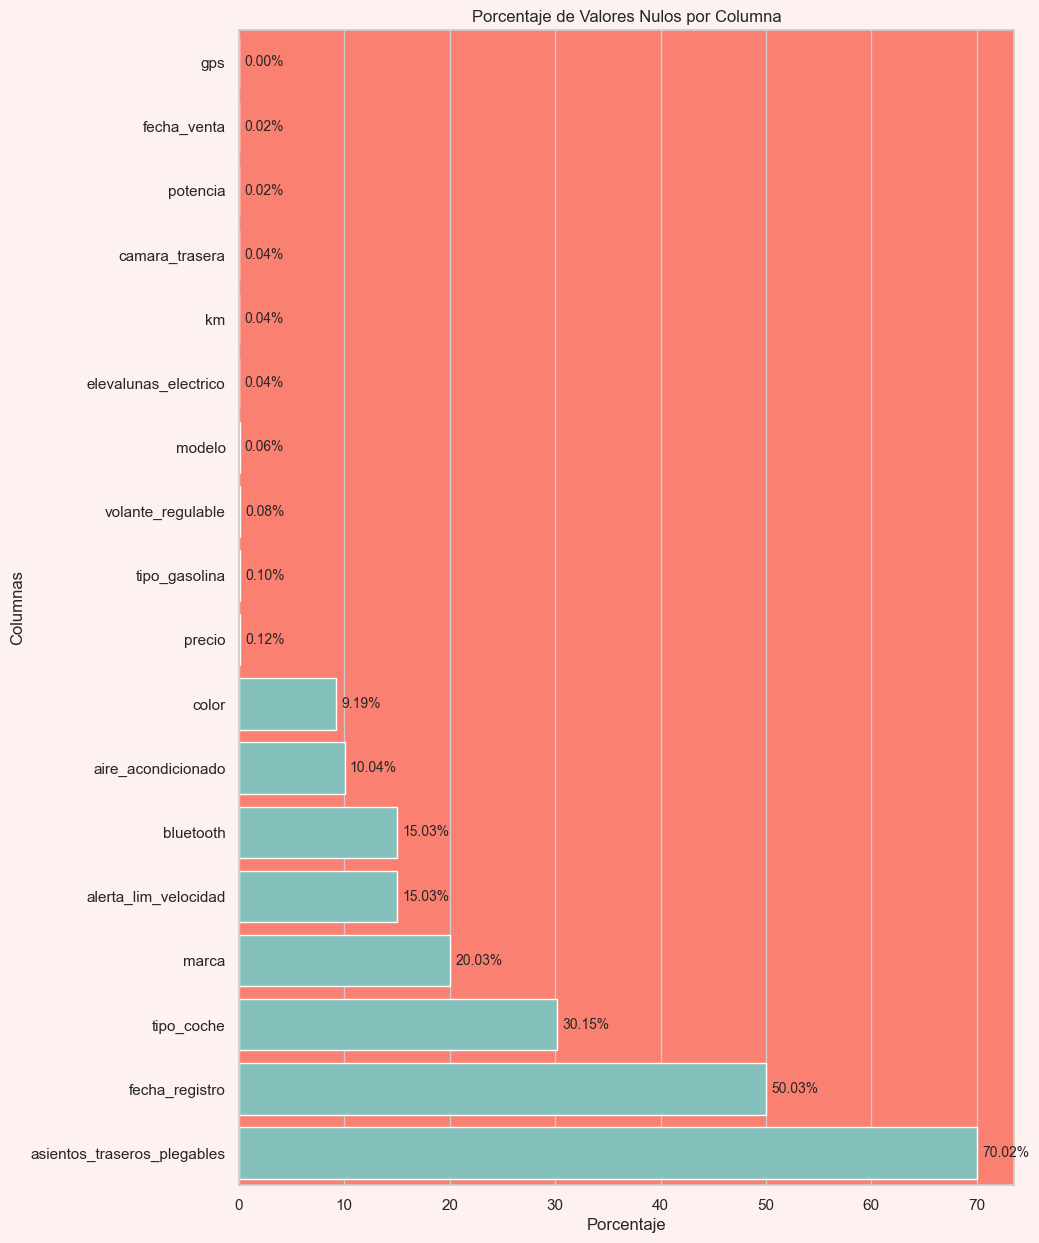

In [95]:
plot_null_values(df_bmw)

In [96]:
# En esta gráfica podemos ver el porcentaje de nulos que tiene cada colummna. Hay varios que tienen un porcentaje significativamente 
# bajo de nulos, por lo tanto, podemos optar por varios procedimientos para rellenarlos. Después hay otras columnas con un porcentaje
# de nulos más elevado, por lo que, se deben tomar decisiones más específicas. De cualquier manera, se intentará conservar lo máximo de 
# información posible. 

In [97]:
# Reemplazamos los valores nulos de la columna de marca, por BMW. Damos por hecho de que todos los valores nulos van a ser de BMW.
df_bmw["marca"] = df_bmw["marca"].fillna("BMW")

In [98]:
# Filtramos estas columnas para sustituir los valores nulos por sus más frecuentes.
columnas_a_modificar = ['modelo','km','potencia','tipo_gasolina','volante_regulable','camara_trasera','elevalunas_electrico','precio','bluetooth','aire_acondicionado','alerta_lim_velocidad']
# Llenamos los valores nulos con la moda de cada columna
for column in columnas_a_modificar:
    mode_value = df_bmw[column].mode()[0]
    df_bmw.loc[df_bmw[column].isnull(), column] = mode_value

# Hemos analizado e visto que cada una de estas columnas solamente tiene uno o dos valores nulos, 3 valores nulos, por lo tanto, hemos
# optado por sustituir esos valores nulos por sus valores más frecuentes. Después están los valores de Bluetooth, alerta_lim_velocidad,
# y aire_acondicionado, esas tienen muchos nulos, pero por feedback de Joseph, aplico la moda a esos booleanos.  


In [99]:
# Agrupamos en una nueva columna las dos columnas de marca y de modelo.
df_bmw['marca_modelo'] = df_bmw['marca'] + ' ' + df_bmw['modelo']

In [100]:
df_bmw['volante_regulable'].isnull().sum()

np.int64(0)

<Axes: >

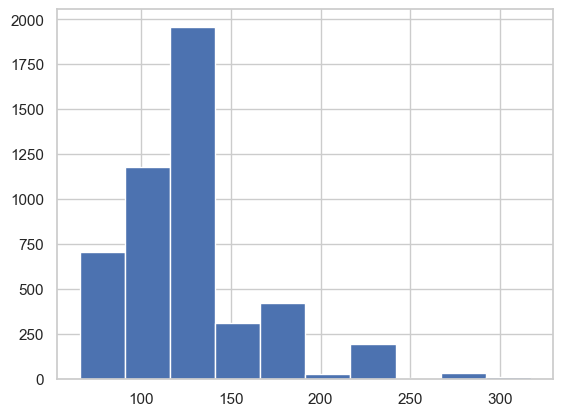

In [101]:
# Quitamos los outliers de la columna 'potencia'.
df_bmw.drop(df_bmw[((df_bmw["potencia"]<=50) | (df_bmw["potencia"]>=400))].index, inplace=True)

df_bmw['potencia'].hist()

In [102]:
# Hay que analizar los outliers de las columnas de km y precio, si pueden llegar a ser realistas o no. 

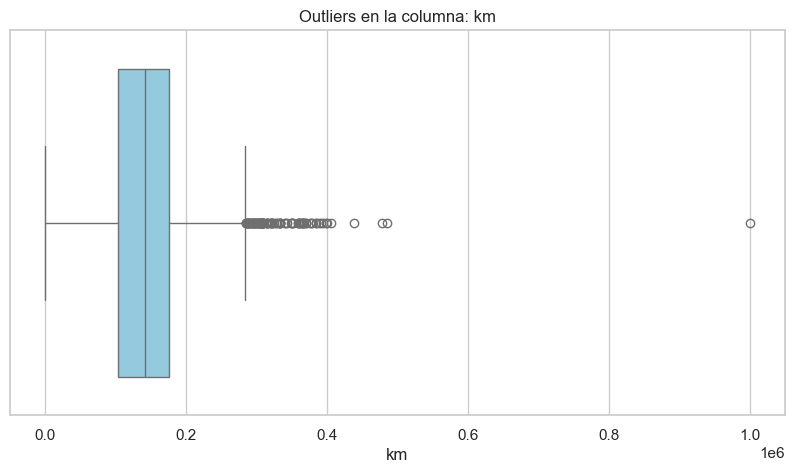

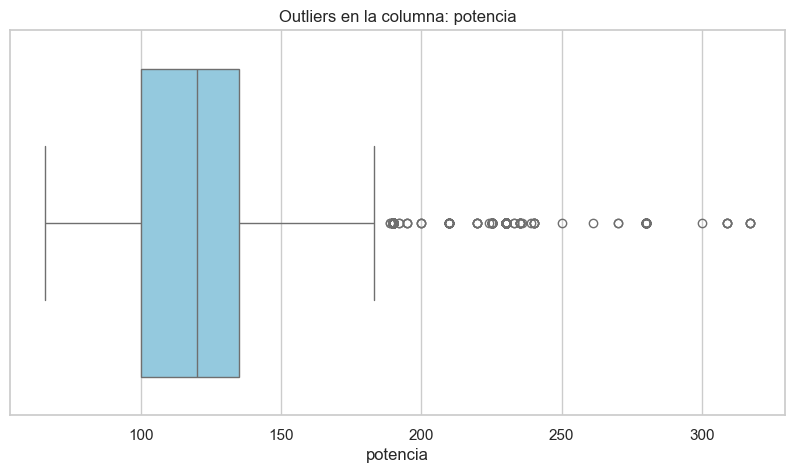

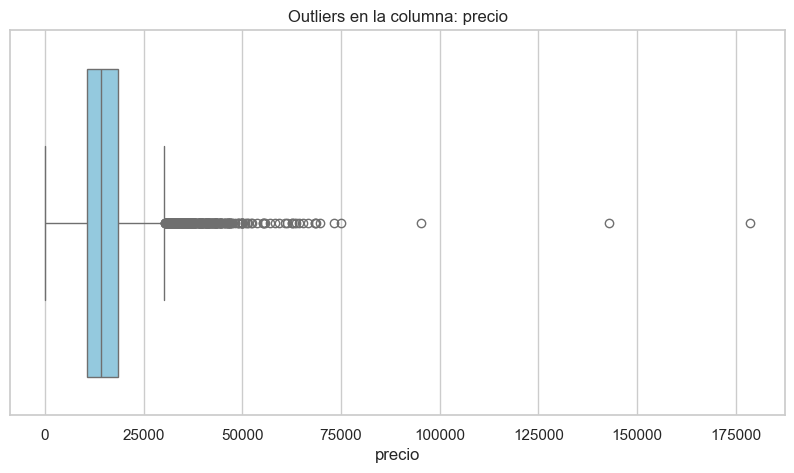

In [103]:
plot_outliers(df_bmw)

In [108]:
outliers_precio = get_sorted_outliers(df_bmw, 'precio')

In [109]:
outliers_precio.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,marca_modelo
4753,BMW,X3,72515.0,135.0,2013-03-01,diesel,blue,suv,False,False,True,NaN,False,False,False,True,178500.0,2018-08-01,BMW X3
4684,BMW,X4,103222.0,140.0,2014-08-01,diesel,grey,suv,True,True,False,NaN,True,False,True,True,142800.0,2018-08-01,BMW X4
90,BMW,i8,12402.0,170.0,NaN,hybrid_petrol,grey,coupe,True,True,False,False,False,False,False,True,95200.0,2018-04-01,BMW i8
2938,BMW,640 Gran Coupé,-64.0,230.0,NaN,diesel,black,sedan,True,True,False,NaN,False,False,True,True,75000.0,2018-04-01,BMW 640 Gran Coupé
4731,BMW,X5 M,4530.0,230.0,2016-07-01,diesel,silver,suv,True,True,False,NaN,False,False,False,True,73100.0,2018-08-01,BMW X5 M


In [110]:
outliers_potencia = get_sorted_outliers(df_bmw, 'potencia')

In [111]:
outliers_potencia.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,marca_modelo
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01,BMW M4
2944,BMW,M3,33670.0,317.0,2014-03-01,petrol,blue,sedan,True,True,False,NaN,False,True,True,True,51200.0,2018-04-01,BMW M3
3092,BMW,M3,39250.0,317.0,2015-11-01,petrol,black,sedan,True,True,False,NaN,False,True,True,True,52400.0,2018-05-01,BMW M3
72,BMW,M4,69410.0,317.0,2015-02-01,petrol,white,NaN,True,True,False,NaN,False,True,True,True,53600.0,2018-03-01,BMW M4
73,BMW,M3,170550.0,309.0,NaN,petrol,grey,coupe,True,True,False,NaN,True,False,True,True,28000.0,2018-03-01,BMW M3


In [112]:
outliers_km = get_sorted_outliers(df_bmw, 'km')

In [113]:
outliers_km.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,marca_modelo
3732,BMW,118,1000376.0,90.0,2005-03-01,diesel,NaN,NaN,True,False,False,False,False,False,True,False,1400.0,2018-06-01,BMW 118
557,BMW,520,484615.0,120.0,2011-02-01,diesel,blue,estate,True,True,False,NaN,False,False,True,False,8300.0,2018-03-01,BMW 520
2350,BMW,318,477571.0,85.0,NaN,diesel,grey,NaN,False,True,False,NaN,False,True,False,False,1200.0,2018-07-01,BMW 318
2829,BMW,525,439060.0,105.0,NaN,diesel,silver,NaN,False,False,True,NaN,False,False,True,False,100.0,2018-03-01,BMW 525
3198,BMW,320,405816.0,100.0,2000-02-01,diesel,blue,sedan,False,False,False,NaN,False,False,True,False,500.0,2018-05-01,BMW 320


In [ ]:
# Aqui podemos ver claramente que en la columna de km hay outliers, ya que es bastante irreal el valor de km. 

In [21]:
# Cambiamos los valores nulos de las columnas de color y tipo coche, por 'sin especificar'.
df_bmw['color'] = df_bmw['color'].fillna('sin especificar')
df_bmw['tipo_coche'] = df_bmw['tipo_coche'].fillna('sin especificar')

df_bmw.isnull().sum()

marca                             0
modelo                            0
km                                0
potencia                          0
fecha_registro                 2420
tipo_gasolina                     0
color                             0
tipo_coche                        0
volante_regulable                 0
aire_acondicionado                0
camara_trasera                    0
asientos_traseros_plegables    3388
elevalunas_electrico              0
bluetooth                         0
gps                               0
alerta_lim_velocidad              0
precio                            0
fecha_venta                       1
marca_modelo                      0
dtype: int64

In [22]:
df_bmw['fecha_venta'] = df_bmw['fecha_venta'].fillna(method='ffill')

C:\Users\mitev\AppData\Local\Temp\ipykernel_16616\3554361723.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bmw['fecha_venta'] = df_bmw['fecha_venta'].fillna(method='ffill')


In [23]:
df_bmw.isnull().sum()

marca                             0
modelo                            0
km                                0
potencia                          0
fecha_registro                 2420
tipo_gasolina                     0
color                             0
tipo_coche                        0
volante_regulable                 0
aire_acondicionado                0
camara_trasera                    0
asientos_traseros_plegables    3388
elevalunas_electrico              0
bluetooth                         0
gps                               0
alerta_lim_velocidad              0
precio                            0
fecha_venta                       0
marca_modelo                      0
dtype: int64

In [24]:
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4838 entries, 0 to 4842
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4838 non-null   object 
 1   modelo                       4838 non-null   object 
 2   km                           4838 non-null   float64
 3   potencia                     4838 non-null   float64
 4   fecha_registro               2418 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4838 non-null   object 
 7   tipo_coche                   4838 non-null   object 
 8   volante_regulable            4838 non-null   object 
 9   aire_acondicionado           4838 non-null   object 
 10  camara_trasera               4838 non-null   object 
 11  asientos_traseros_plegables  1450 non-null   object 
 12  elevalunas_electrico         4838 non-null   object 
 13  bluetooth              

In [25]:
columnas = ['fecha_registro','asientos_traseros_plegables']
resultados = porcentaje_nulos(df_bmw, columnas)

for columna, porcentaje in resultados.items():
    print(f'Porcentaje de nulos en {columna}: {porcentaje:.2f}%')

Porcentaje de nulos en fecha_registro: 50.02%
Porcentaje de nulos en asientos_traseros_plegables: 70.03%


In [26]:
# Podemos ver que estas dos columnas tienen un porcentaje elevado de valores nulos. En este caso, voy a tomar la decision de borrar
# esas columnas ya que no contienen suficiente información para alimentar el modelo. Para el caso de las columnas de marca y modelo,
# las borramos porque ya creamos una nueva columna, la cuál es el resultado de estas dos.

In [27]:
columnas_a_borrar = ['fecha_registro','asientos_traseros_plegables','marca','modelo']
df_bmw = df_bmw.drop(columns=columnas_a_borrar)

In [28]:
df_bmw.isnull().sum()

km                      0
potencia                0
tipo_gasolina           0
color                   0
tipo_coche              0
volante_regulable       0
aire_acondicionado      0
camara_trasera          0
elevalunas_electrico    0
bluetooth               0
gps                     0
alerta_lim_velocidad    0
precio                  0
fecha_venta             0
marca_modelo            0
dtype: int64

In [29]:
# Aqui convertimos todas las columnas booleanas en numéricas para su posterios procesamiento.
columnas_a_convertir = ['volante_regulable', 'aire_acondicionado', 'camara_trasera','elevalunas_electrico','bluetooth','gps','alerta_lim_velocidad']

for col in columnas_a_convertir:
    df_bmw[col] = df_bmw[col].astype('int64')

df_bmw.head()

,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,marca_modelo
0,140411.0,100.0,diesel,black,sin especificar,1,1,0,1,0,1,1,11300.0,2018-01-01,BMW 118
1,13929.0,317.0,petrol,grey,convertible,1,1,0,0,1,1,1,69700.0,2018-02-01,BMW M4
2,183297.0,120.0,diesel,white,sin especificar,0,0,0,1,0,1,0,10200.0,2018-02-01,BMW 320
3,128035.0,135.0,diesel,red,convertible,1,1,0,1,1,1,1,25100.0,2018-02-01,BMW 420
4,97097.0,160.0,diesel,silver,sin especificar,1,1,0,0,1,1,1,33400.0,2018-04-01,BMW 425


In [30]:
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4838 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   km                    4838 non-null   float64
 1   potencia              4838 non-null   float64
 2   tipo_gasolina         4838 non-null   object 
 3   color                 4838 non-null   object 
 4   tipo_coche            4838 non-null   object 
 5   volante_regulable     4838 non-null   int64  
 6   aire_acondicionado    4838 non-null   int64  
 7   camara_trasera        4838 non-null   int64  
 8   elevalunas_electrico  4838 non-null   int64  
 9   bluetooth             4838 non-null   int64  
 10  gps                   4838 non-null   int64  
 11  alerta_lim_velocidad  4838 non-null   int64  
 12  precio                4838 non-null   float64
 13  fecha_venta           4838 non-null   object 
 14  marca_modelo          4838 non-null   object 
dtypes: float64(3), int64(7), o

In [31]:
df_bmw['tipo_gasolina'].value_counts()

tipo_gasolina
diesel           4635
petrol            189
hybrid_petrol       6
Diesel              5
electro             3
Name: count, dtype: int64

In [32]:
df_bmw['tipo_gasolina'] = df_bmw['tipo_gasolina'].str.lower()
df_bmw['tipo_gasolina'].value_counts()

tipo_gasolina
diesel           4640
petrol            189
hybrid_petrol       6
electro             3
Name: count, dtype: int64

In [33]:
df_bmw['color'].value_counts()

color
black              1497
grey               1070
blue                647
white               482
sin especificar     445
brown               302
silver              292
red                  46
beige                37
green                14
orange                6
Name: count, dtype: int64

## Agrupaciones

In [34]:
# Agrupamos por 'marca' y calcular promedio de 'km' y 'potencia'.
grouped_by_marca = df_bmw.groupby('marca_modelo').agg({'km': 'mean', 'potencia': 'mean'}).reset_index()
print("Promedio de km y potencia por marca:")
print(grouped_by_marca)

Promedio de km y potencia por marca:
          marca_modelo             km    potencia
0   BMW  Active Tourer   48380.000000  100.000000
1              BMW 114   73788.333333   71.666667
2              BMW 116  117921.005587   85.245810
3              BMW 118  136791.230769  103.335664
4              BMW 120  134157.444444  132.277778
..                 ...            ...         ...
70              BMW X6  124492.840909  213.090909
71            BMW X6 M   83695.571429  232.142857
72              BMW Z4  104595.666667  129.166667
73              BMW i3   39553.250000   87.500000
74              BMW i8   12402.000000  170.000000

[75 rows x 3 columns]


In [35]:
# Agrupamos por 'tipo_coche' y calcular promedio de 'km' y 'potencia'.
grouped_by_tipo_coche = df_bmw.groupby('tipo_coche').agg({'km': 'mean', 'potencia': 'mean'}).reset_index()
print("\nPromedio de km y potencia por tipo de coche:")
print(grouped_by_tipo_coche)


Promedio de km y potencia por tipo de coche:
        tipo_coche             km    potencia
0      convertible  115475.700000  139.400000
1            coupe  116294.526316  162.763158
2           estate  155710.752484  125.925023
3        hatchback  123546.299795  108.361396
4            sedan  148980.976829  131.157317
5  sin especificar  141294.276902  128.338588
6       subcompact  126653.961039   87.987013
7              suv  128298.216467  146.478088
8              van   84075.000000  109.965517


In [36]:
# Además de esto, se puede optar por hacer algunas agrupaciones estratégicas que midan la media de km por modelo,y guardamos esos resultados
# en una nueva variable del dataset. 

# Análisis Univariable y Correlación Inicial

In [37]:
# PRIMERA VISUALIZACIÓN DE CORRELACIONES ENTRE COLUMNAS NUMÉRICAS
corr = df_bmw.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio
km,1.000000,-0.048468,0.066053,0.014311,0.002953,0.045939,-0.031477,0.154257,-0.037964,-0.409641
potencia,-0.048468,1.000000,0.327021,0.181985,0.310563,0.343222,0.203799,0.005904,0.429542,0.636540
volante_regulable,0.066053,0.327021,1.000000,0.285819,0.252881,0.277754,0.125540,0.243983,0.189731,0.267799
aire_acondicionado,0.014311,0.181985,0.285819,1.000000,0.142985,0.258176,0.103231,0.342761,0.172593,0.224432
camara_trasera,0.002953,0.310563,0.252881,0.142985,1.000000,0.198475,0.125543,0.061697,0.166966,0.248708
elevalunas_electrico,0.045939,0.343222,0.277754,0.258176,0.198475,1.000000,0.231649,0.202977,0.300021,0.262985
bluetooth,-0.031477,0.203799,0.125540,0.103231,0.125543,0.231649,1.000000,0.114846,0.076226,0.184728
gps,0.154257,0.005904,0.243983,0.342761,0.061697,0.202977,0.114846,1.000000,-0.052516,-0.006299
alerta_lim_velocidad,-0.037964,0.429542,0.189731,0.172593,0.166966,0.300021,0.076226,-0.052516,1.000000,0.385065
precio,-0.409641,0.636540,0.267799,0.224432,0.248708,0.262985,0.184728,-0.006299,0.385065,1.000000


# ANÁLISIS DE VARIABLE VS TARGET

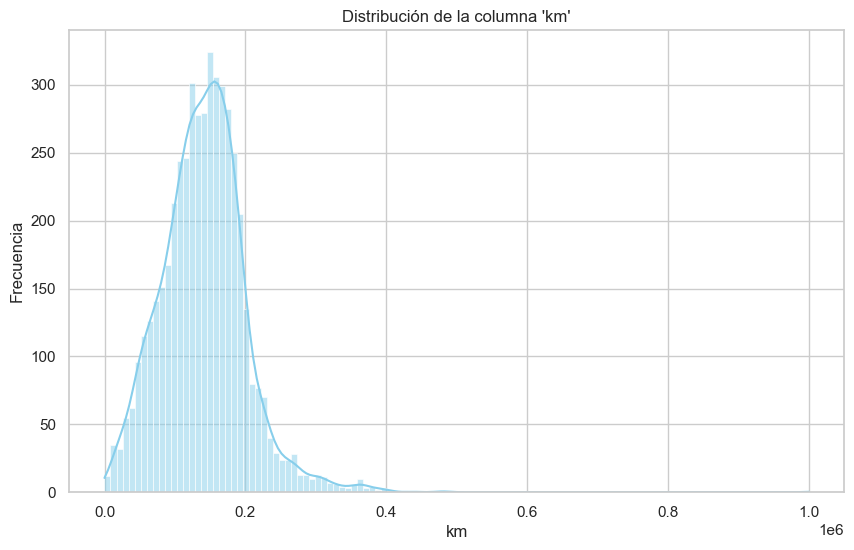

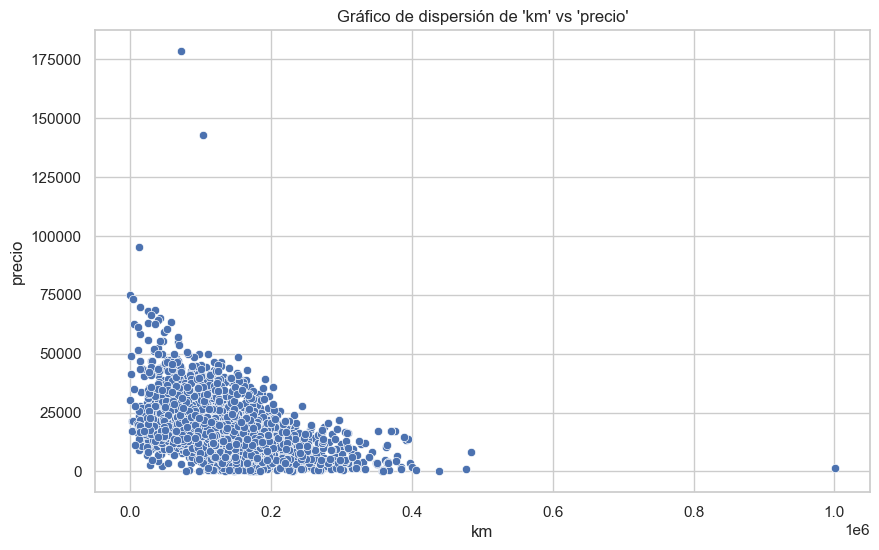

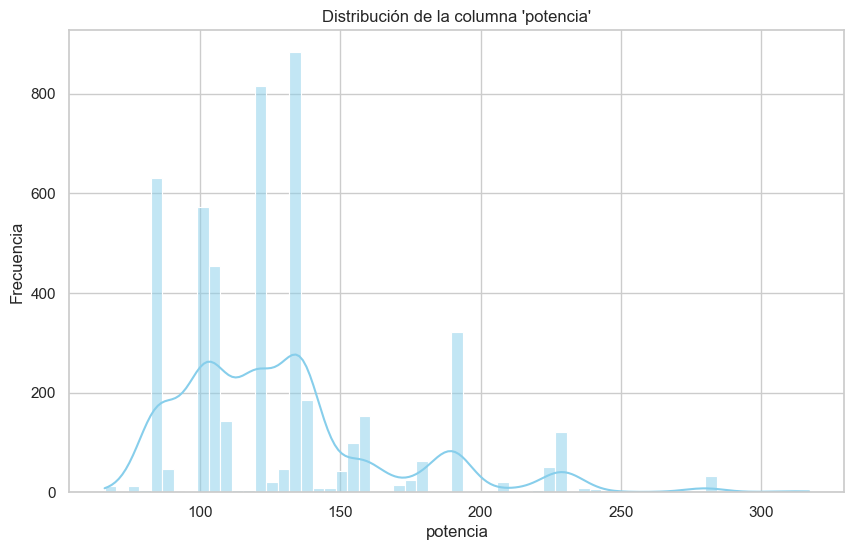

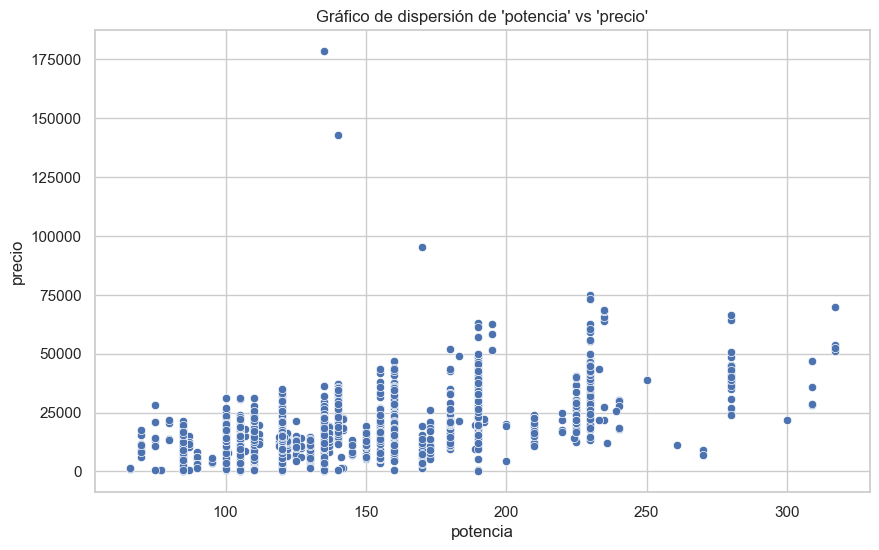

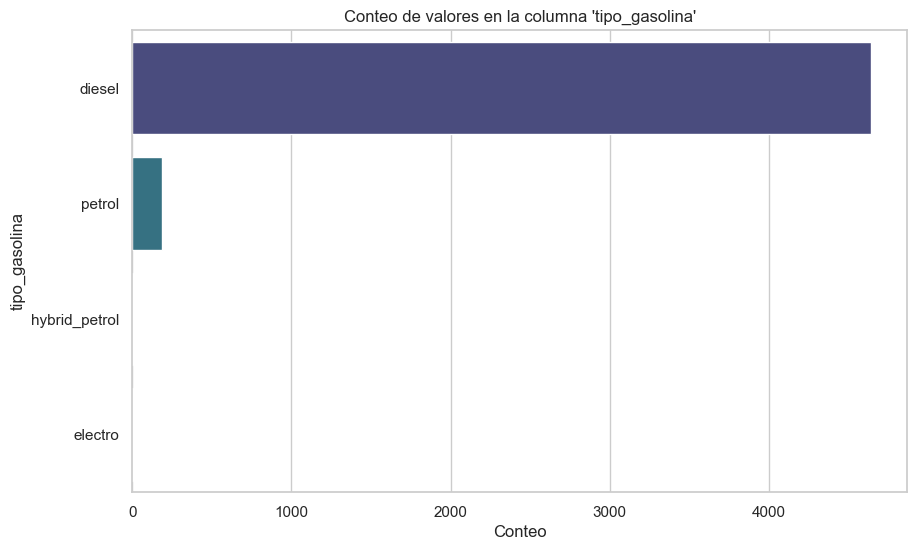

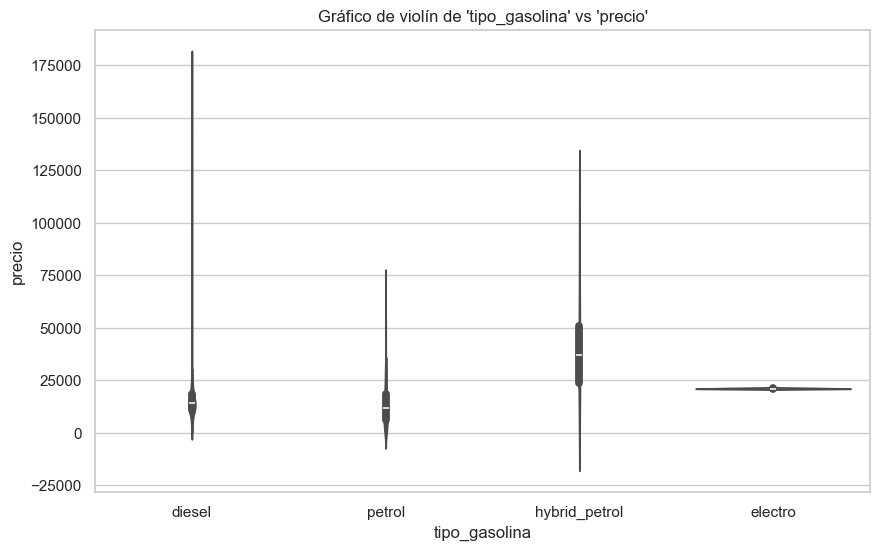

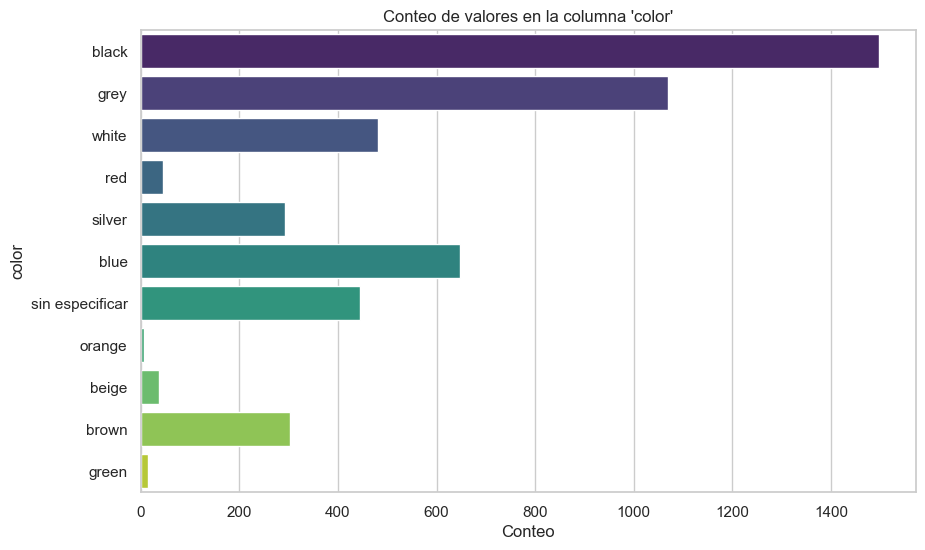

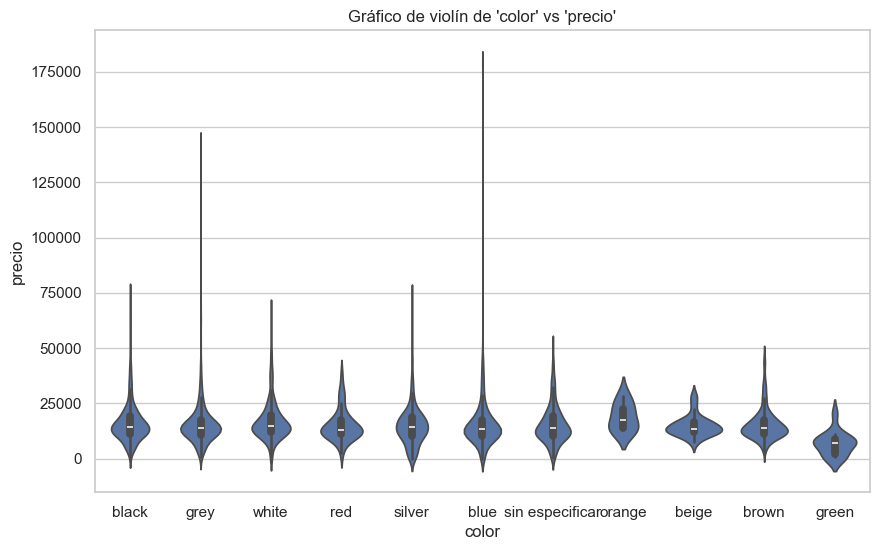

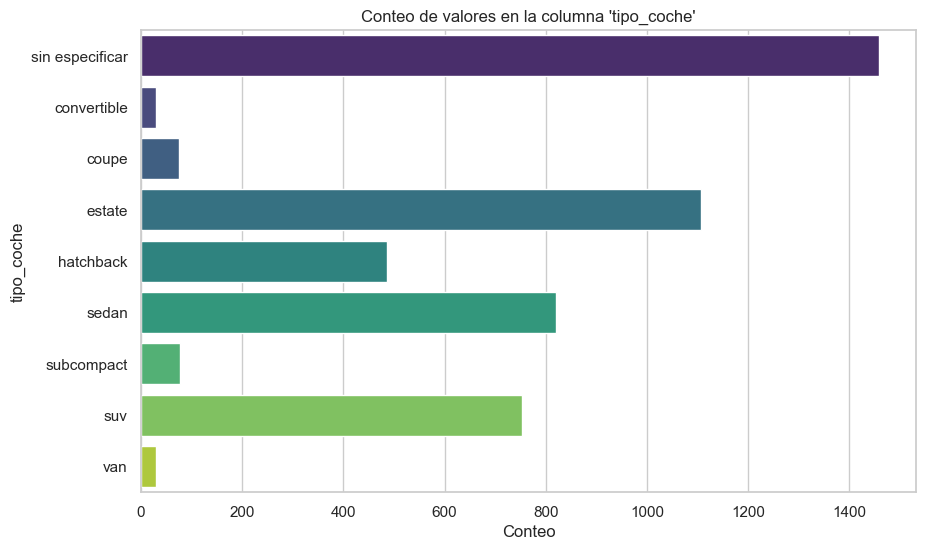

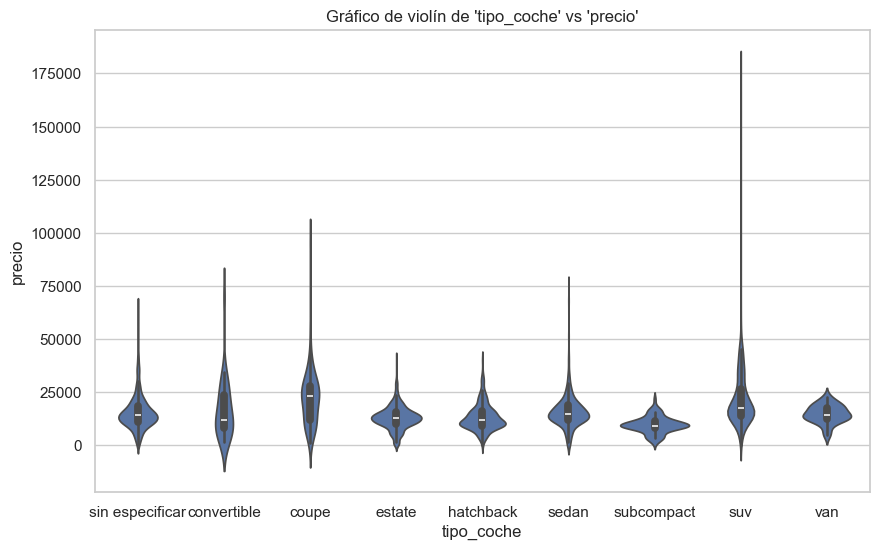

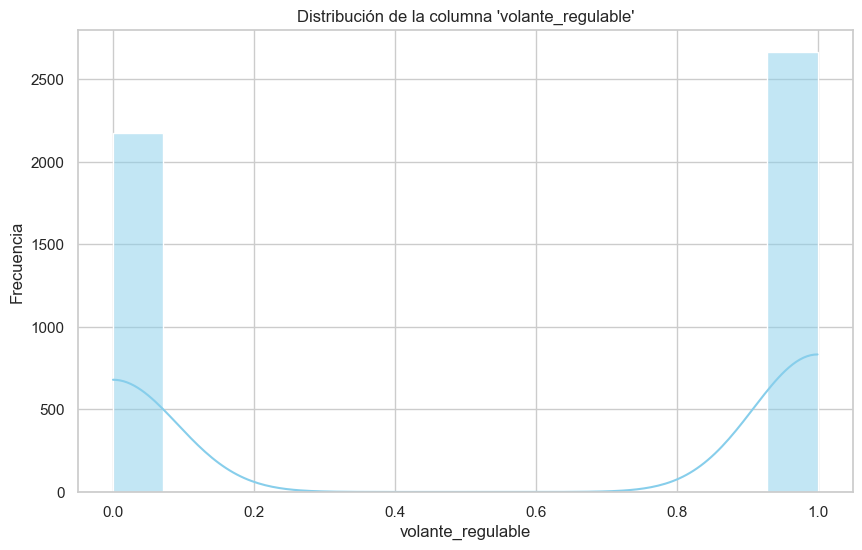

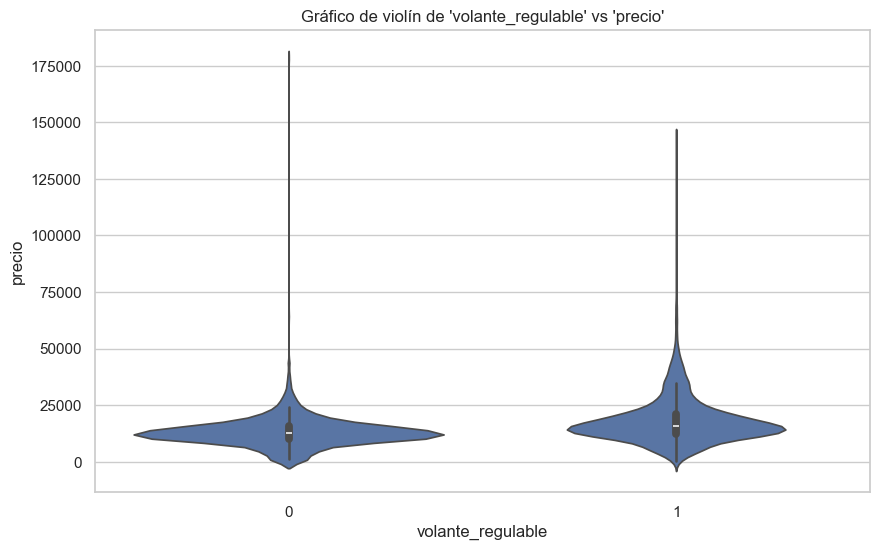

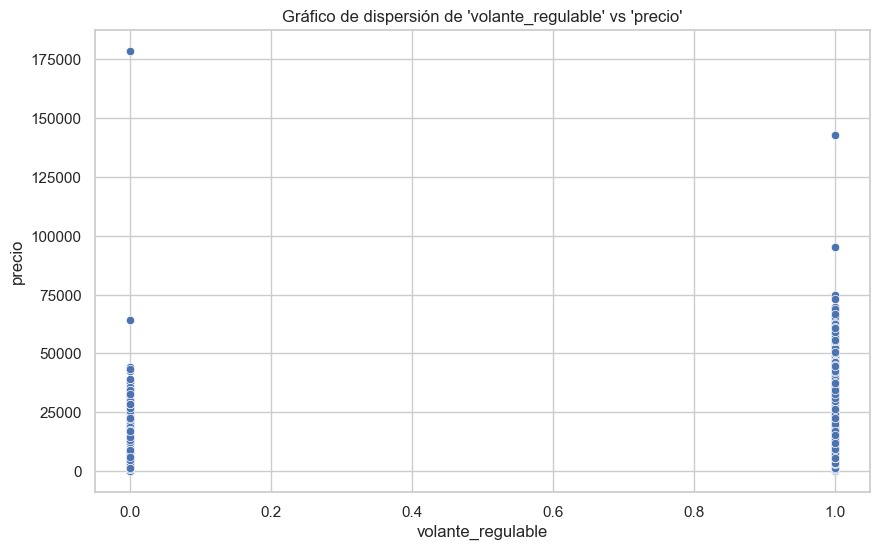

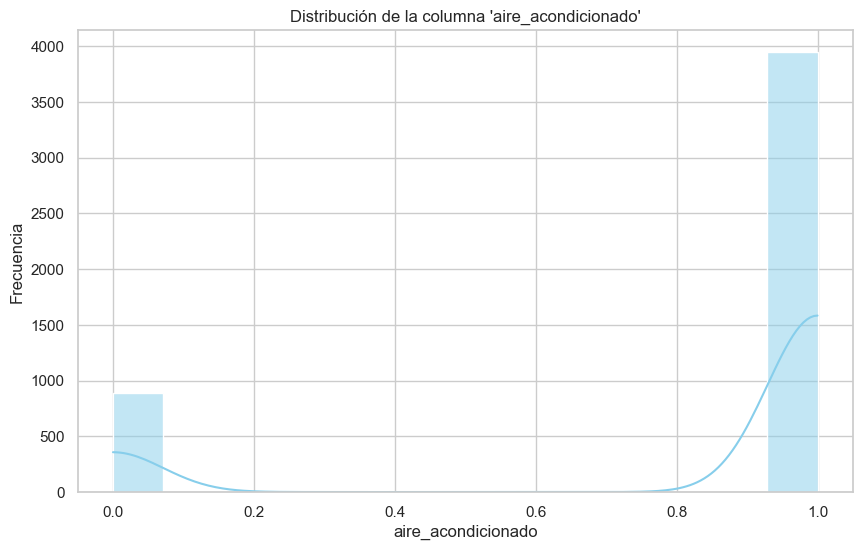

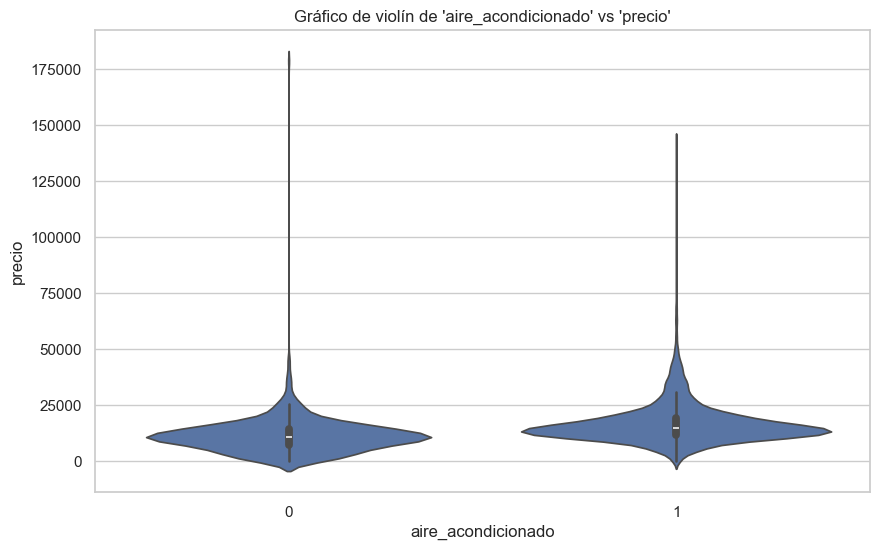

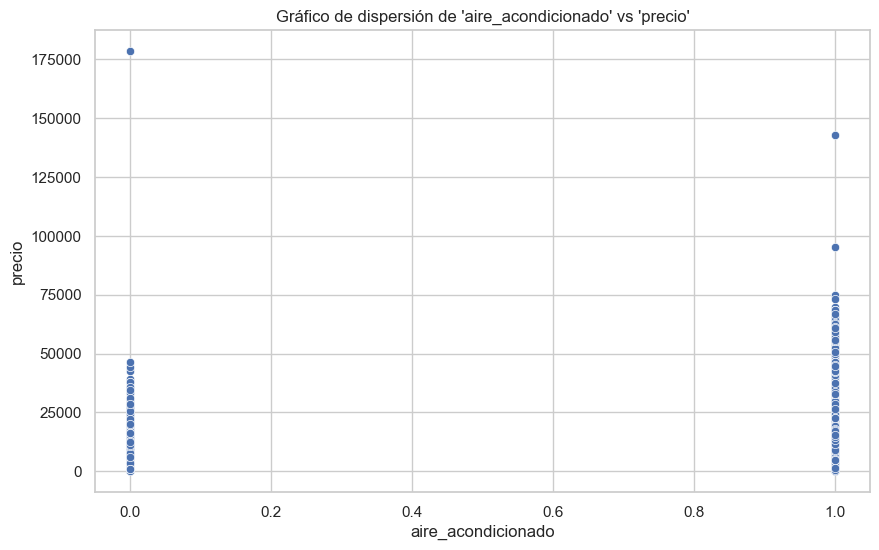

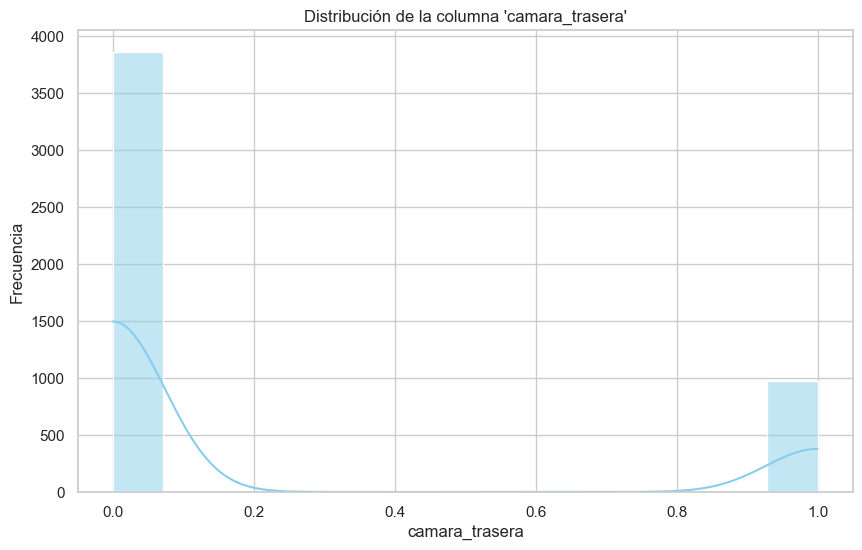

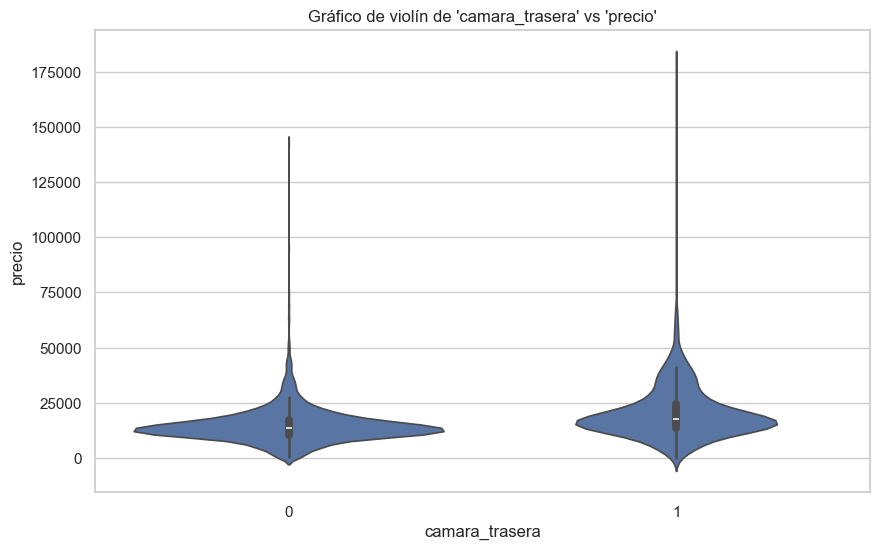

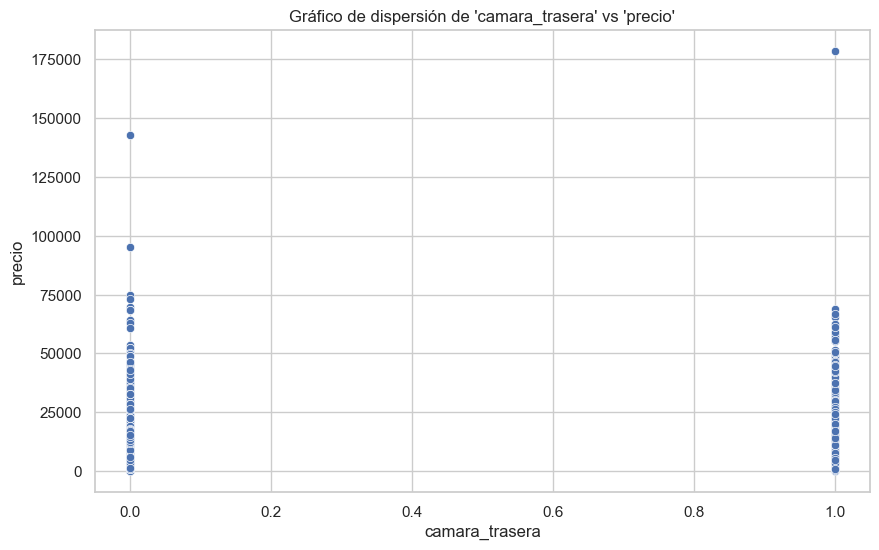

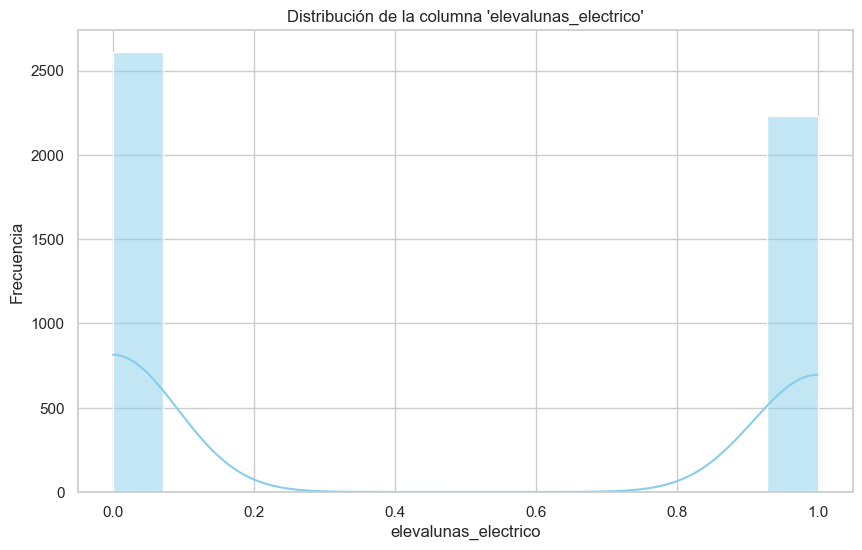

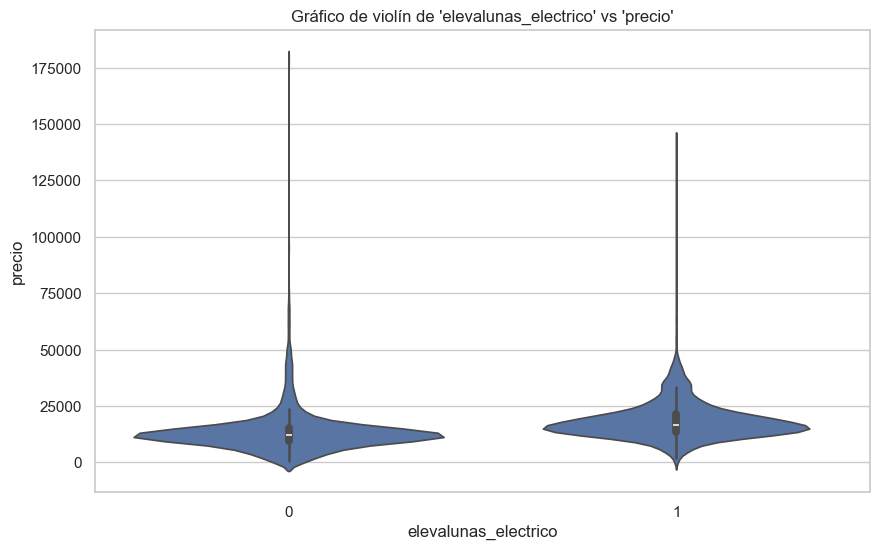

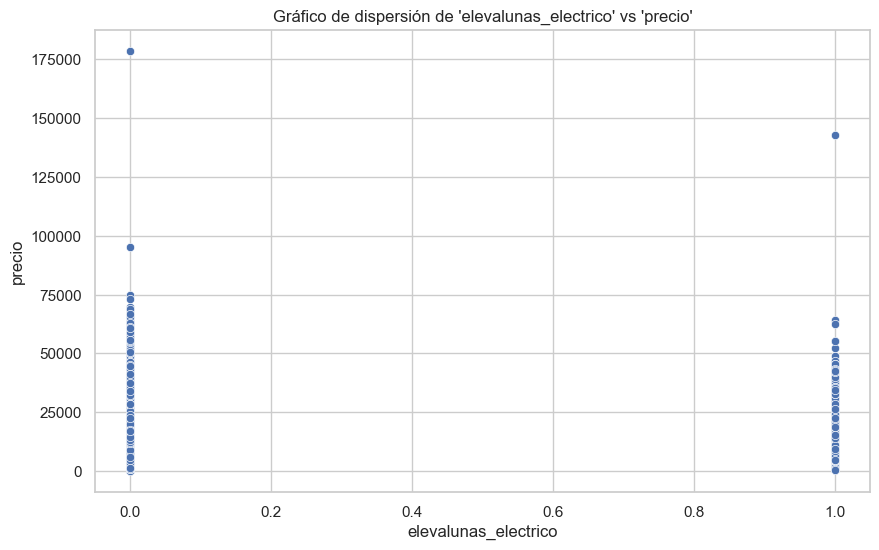

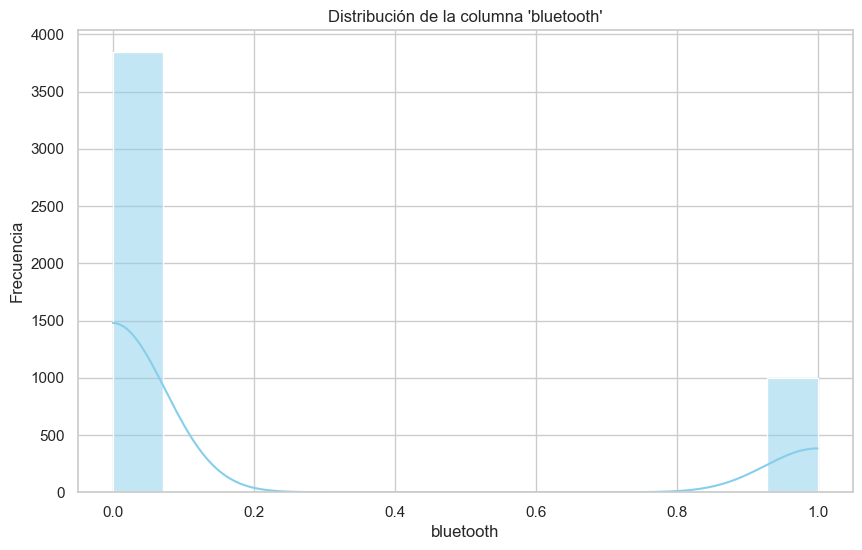

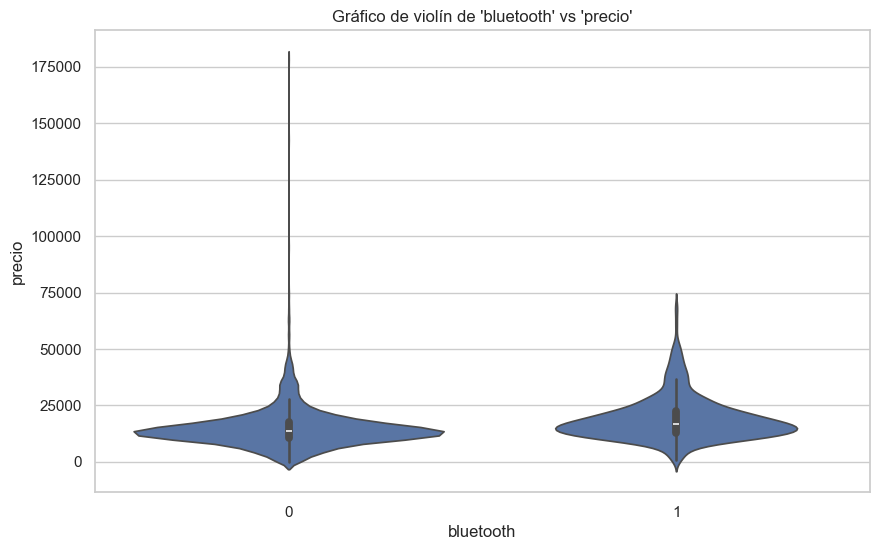

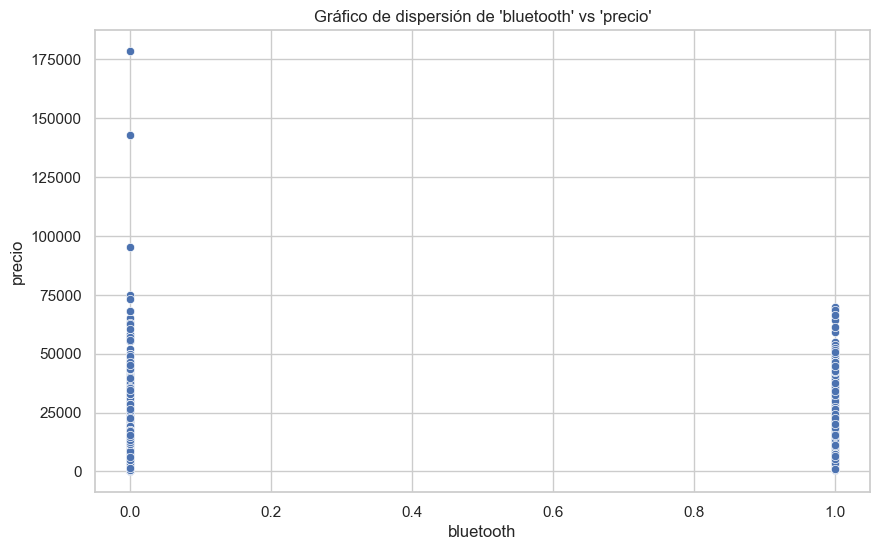

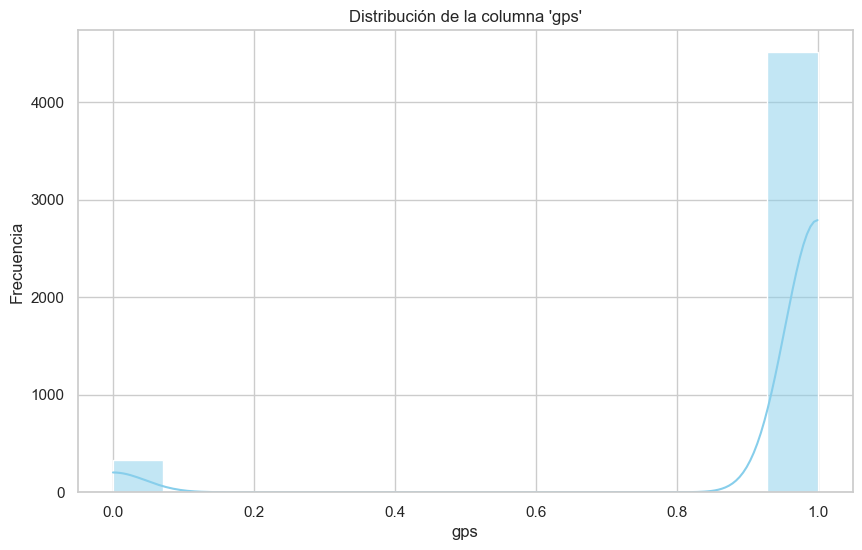

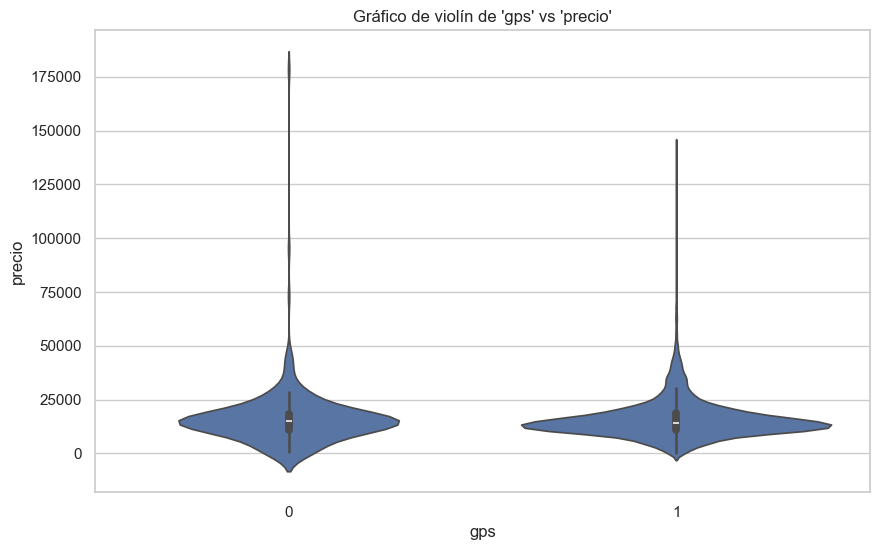

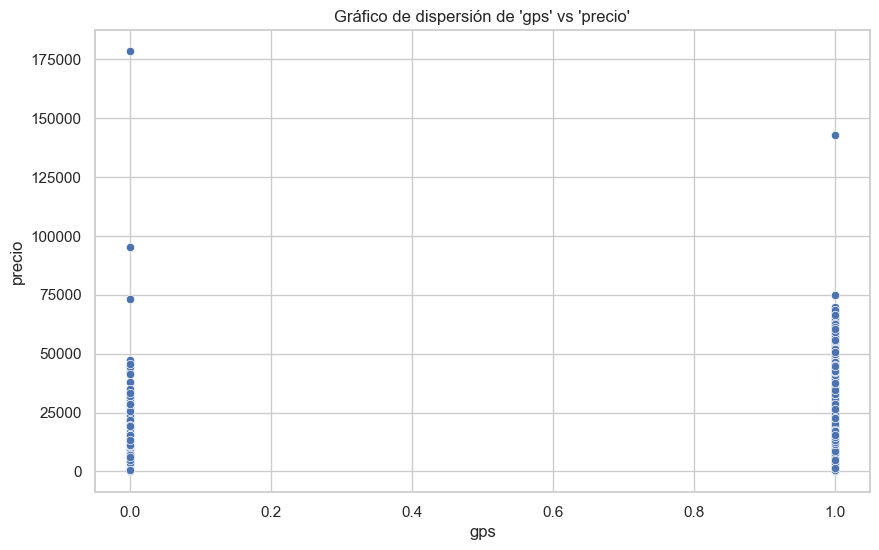

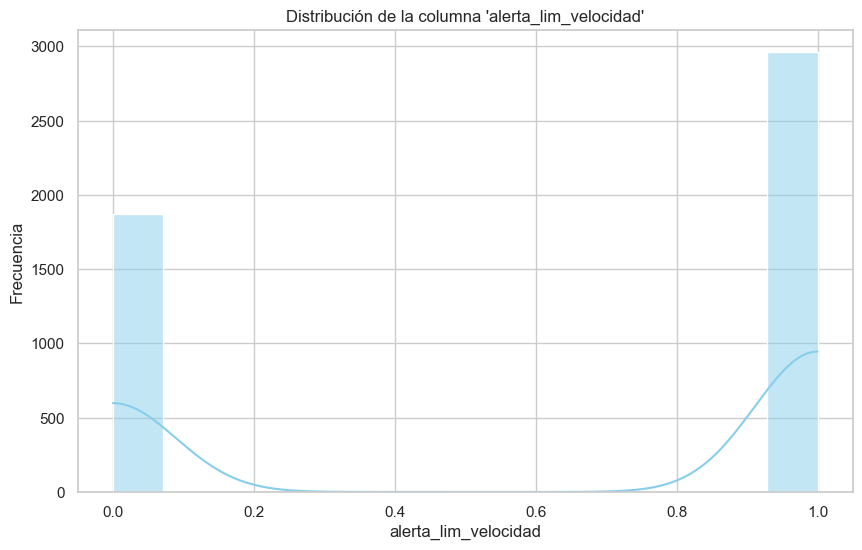

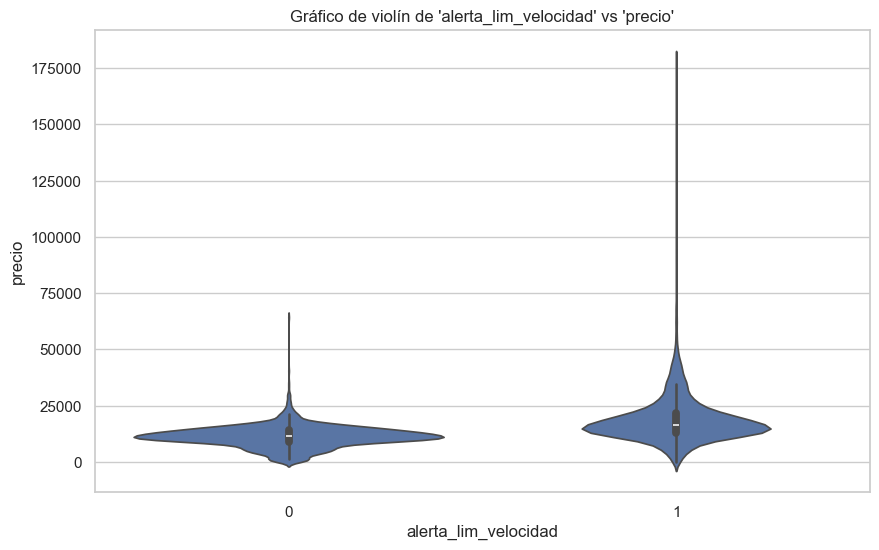

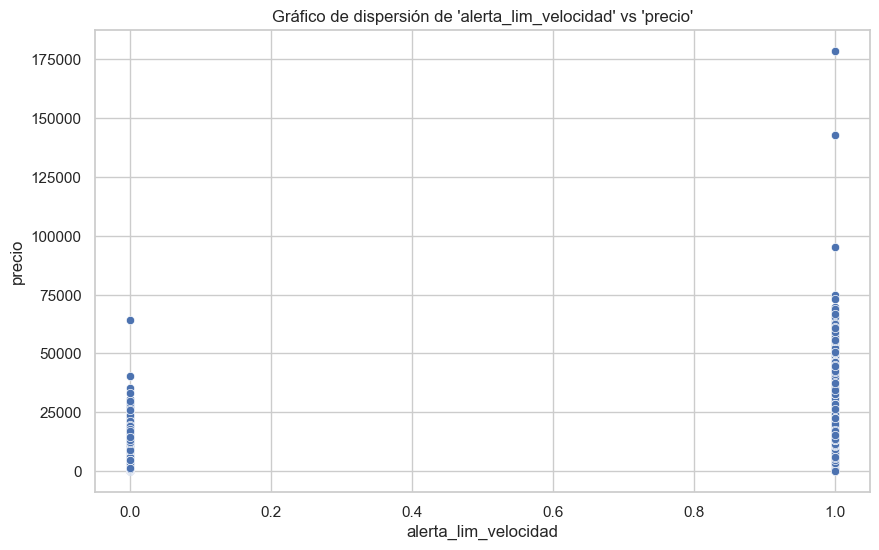

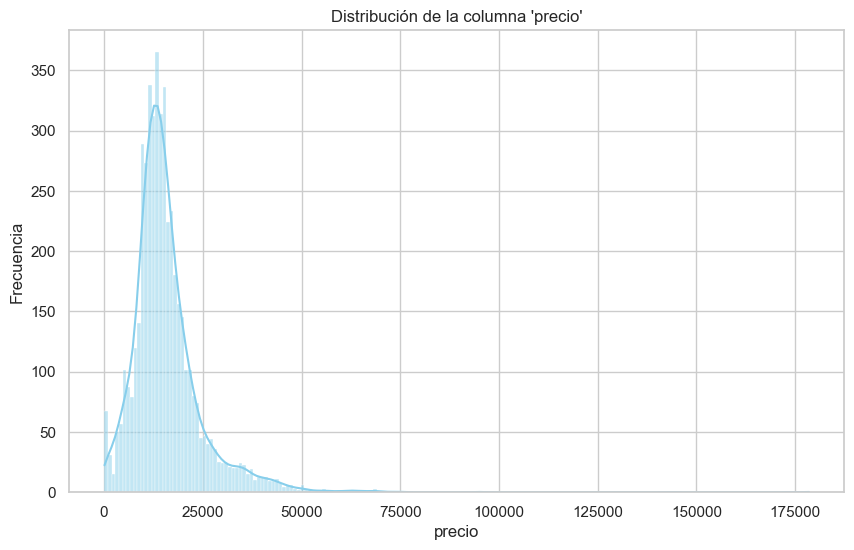

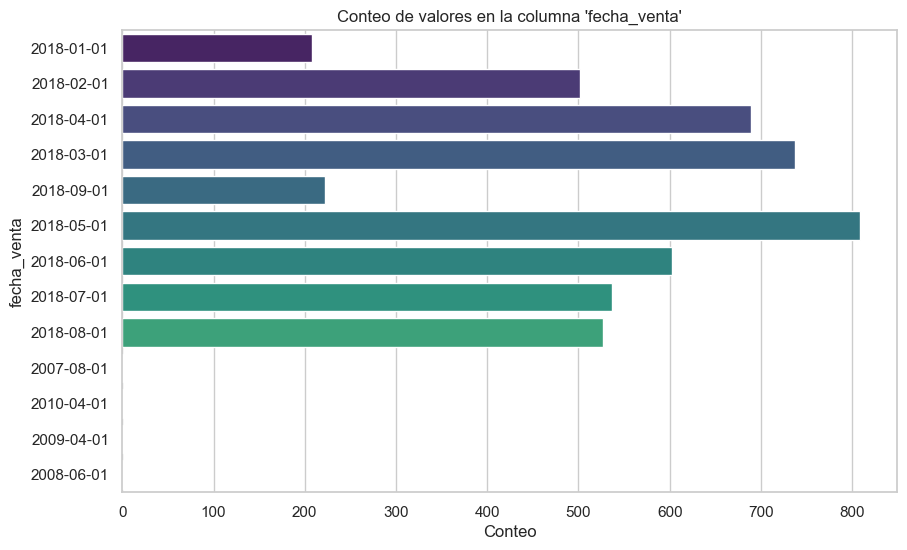

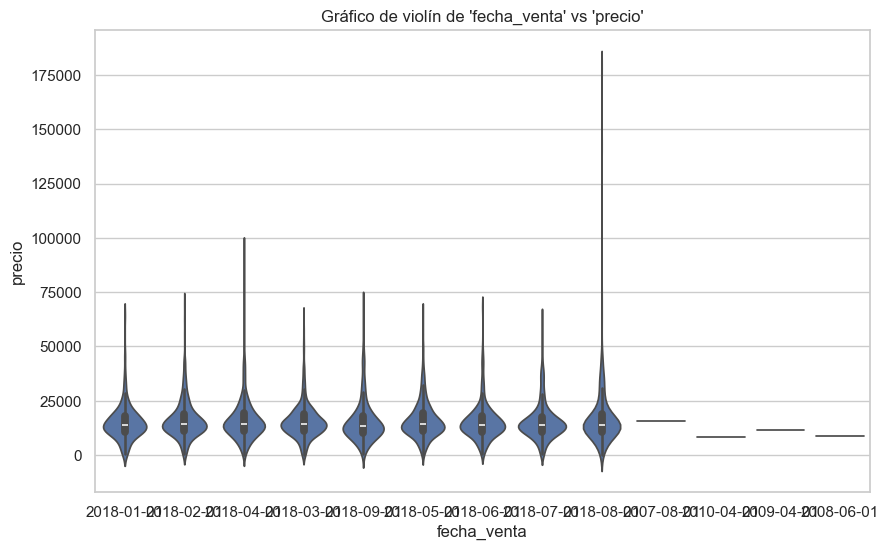

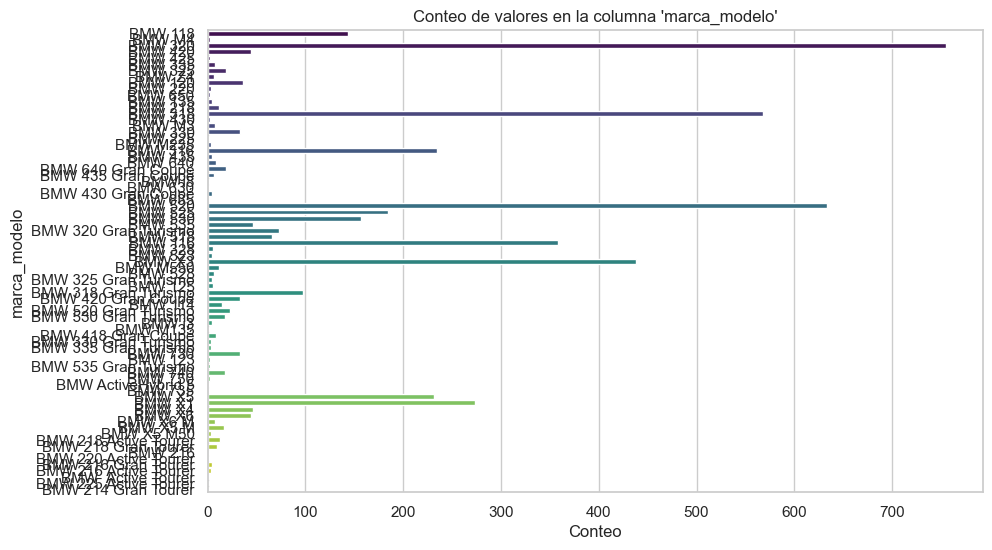

In [38]:
visualize_data(df_bmw)

<Axes: xlabel='precio'>

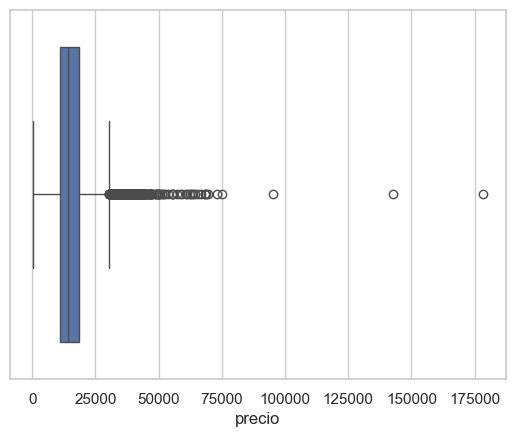

In [39]:
sns.boxplot(x=df_bmw["precio"])

<Axes: xlabel='LOG_PRECIO'>

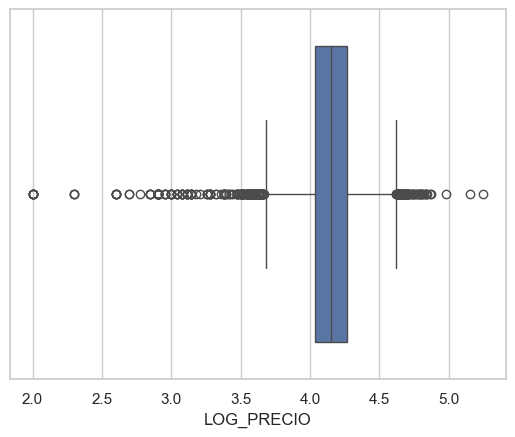

In [40]:
# Creamos una nueva variable llamada LOG Precio.
df_bmw["LOG_PRECIO"]=np.log10(df_bmw["precio"])
sns.boxplot(x=df_bmw["LOG_PRECIO"])

array([[<Axes: title={'center': 'LOG_PRECIO'}>]], dtype=object)

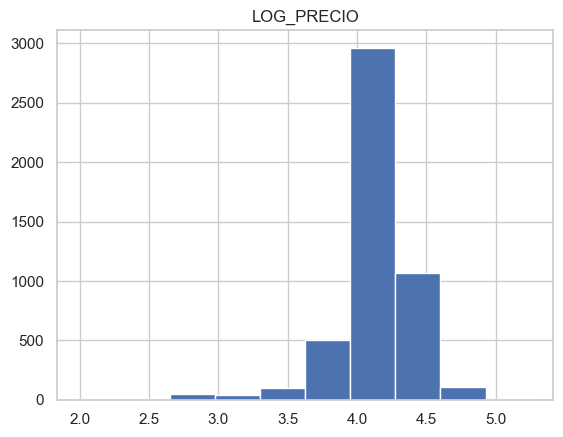

In [41]:
df_bmw.hist("LOG_PRECIO")

<Axes: xlabel='RAIZ_PRECIO'>

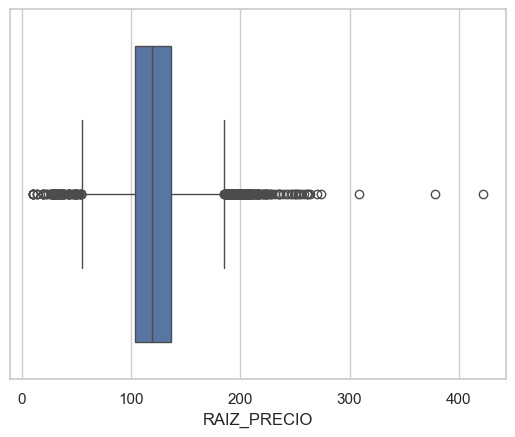

In [42]:
# Creamos una nueva columna llamada Raíz Precio para ayudar a reducir el sesgo y mejorar la distribución.
df_bmw["RAIZ_PRECIO"]=np.sqrt(df_bmw["precio"])
sns.boxplot(x=df_bmw["RAIZ_PRECIO"])

array([[<Axes: title={'center': 'RAIZ_PRECIO'}>]], dtype=object)

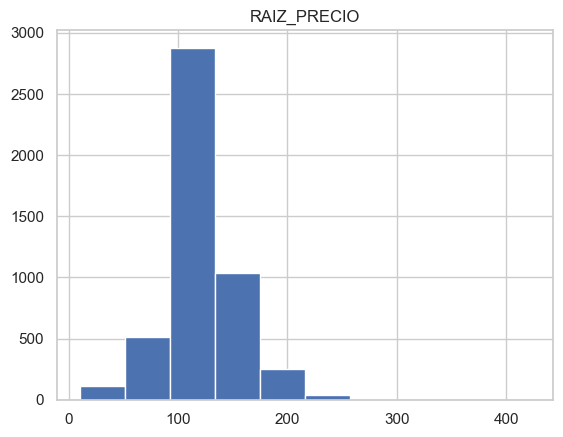

In [43]:
df_bmw.hist("RAIZ_PRECIO")

## Transformación de Datos

In [44]:
lista_numericas, lista_boolean, lista_categoricas= obtener_lista_variables(df_bmw)

In [45]:
lista_categoricas

['tipo_gasolina', 'color', 'tipo_coche', 'fecha_venta', 'marca_modelo']

In [46]:
lista_numericas

['km', 'potencia']

In [47]:
lista_boolean

['volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'elevalunas_electrico',
 'bluetooth',
 'gps',
 'alerta_lim_velocidad']

In [48]:
# Guardamos en un dataset nuevo el target, para poder normalizar el resto de columnas. 
df_bmw_target= df_bmw[['precio','RAIZ_PRECIO','LOG_PRECIO']]

In [49]:
df_bmw_prep=pd.get_dummies(data=df_bmw,columns=lista_categoricas).astype('int64')

In [50]:
df_bmw_prep.head()

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,...,marca_modelo_BMW X3,marca_modelo_BMW X4,marca_modelo_BMW X5,marca_modelo_BMW X5 M,marca_modelo_BMW X5 M50,marca_modelo_BMW X6,marca_modelo_BMW X6 M,marca_modelo_BMW Z4,marca_modelo_BMW i3,marca_modelo_BMW i8
0,140411,100,1,1,0,1,0,1,1,11300,...,0,0,0,0,0,0,0,0,0,0
1,13929,317,1,1,0,0,1,1,1,69700,...,0,0,0,0,0,0,0,0,0,0
2,183297,120,0,0,0,1,0,1,0,10200,...,0,0,0,0,0,0,0,0,0,0
3,128035,135,1,1,0,1,1,1,1,25100,...,0,0,0,0,0,0,0,0,0,0
4,97097,160,1,1,0,0,1,1,1,33400,...,0,0,0,0,0,0,0,0,0,0


In [51]:
columnas_a_eliminar = ['precio','RAIZ_PRECIO','LOG_PRECIO']

df_bmw_prep_2 = df_bmw_prep.drop(columns=columnas_a_eliminar)

In [52]:
df_bmw_prep_2.head()

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,tipo_gasolina_diesel,...,marca_modelo_BMW X3,marca_modelo_BMW X4,marca_modelo_BMW X5,marca_modelo_BMW X5 M,marca_modelo_BMW X5 M50,marca_modelo_BMW X6,marca_modelo_BMW X6 M,marca_modelo_BMW Z4,marca_modelo_BMW i3,marca_modelo_BMW i8
0,140411,100,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,13929,317,1,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,183297,120,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,128035,135,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,97097,160,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [53]:
for i in lista_numericas:
  print(i)

km
potencia


In [54]:
for i in lista_numericas:
  globals()[f"minMax_{i}"] = minmaxTransformacion(i)

In [55]:
df_bmw_prep_2.head()

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,tipo_gasolina_diesel,...,marca_modelo_BMW X3,marca_modelo_BMW X4,marca_modelo_BMW X5,marca_modelo_BMW X5 M,marca_modelo_BMW X5 M50,marca_modelo_BMW X6,marca_modelo_BMW X6 M,marca_modelo_BMW Z4,marca_modelo_BMW i3,marca_modelo_BMW i8
0,140411,100,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,13929,317,1,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,183297,120,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,128035,135,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,97097,160,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Análisis de Correlación Final 

In [56]:
corr2 = df_bmw_prep_2.corr()
corr2.style.background_gradient(cmap='coolwarm')

In [57]:
# Restablecemos los índices del dataset.
df_bmw_prep_2.reset_index(drop= True,inplace=True)